# Positive Pixel Count

In [1]:
# Configuration and imports of other libraries
from __future__ import print_function

import large_image
%matplotlib inline
import matplotlib.pyplot as plt
import skimage.io

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 15, 15
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# Import and alias positive_pixel_count
import histomicstk.segmentation.positive_pixel_count as ppc

## Overview
Positive pixel count is a routine that classifies pixels by their position in
[HSI Color Space](https://en.wikipedia.org/wiki/HSL_and_HSV#Hue_and_chroma)
and computes statistics based on this classification.

HistomicsTK has two main functions for positive pixel counting, `count_slide` and `count_image`,
both of which live in the `histomicstk.segmentation.positive_pixel_count` module
(imported in this notebook as simply `ppc`).  `count_image` operates on an in-memory image
in a format compatible with NumPy's `ndarray` type, and returns both the classification statistics
and a label image that may be useful for visualization or further analysis.

`count_slide` accepts a path to an image instead, and while it can also carry out
exactly the same computation as `count_image`, its advantage lies in its ability to distribute
its computation using [Dask](http://dask.pydata.org/en/latest/index.html) and to operate on images
too large to fit in memory.  This ability comes at a cost &ndash; to enable it, the generation of
the label image must be disabled.  (For the curious, the necessary underlying support for writing
large images a tile at a time is lacking.)  The HistomicsTK CLI `PositivePixelCount` is a wrapper
around this function.

The rest of this example is subdivided, in order, into `count_image` and `count_slide` examples, followed by a CLI example.

## Analyzing a small image with `count_image`
We start with `count_image`.  The image we will look at is small and can be analyzed quickly.

Input image


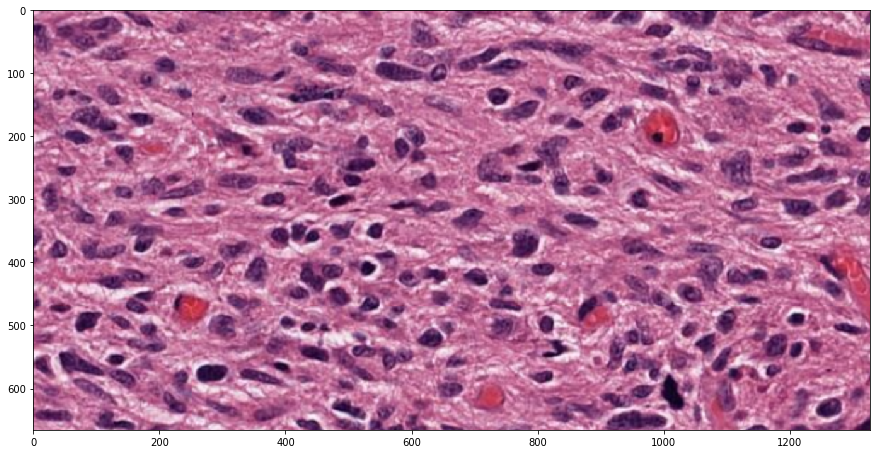

In [3]:
image_url = ('https://data.kitware.com/api/v1/file/'
             '57802ac38d777f12682731a2/download')  # H&E.png

im_input = skimage.io.imread(image_url)

print('Input image')
plt.imshow(im_input)
plt.show()

With a helper function, it becomes reasonable to use `count_image` interactively
to explore parameter values.  A more advanced analysis might also look at the HSI values directly.

Here, we show briefly how one can use the helper function `count_and_label` defined below.

In [4]:
def count_and_label(params):
    "Compute the label image with count_image, and then display it"
    label_image = ppc.count_image(im_input, params)[1]
    plt.imshow(label_image)
    plt.show()

To start out, we'll pick a set of parameters.  The HSI color space used by the routines
is defined to use values in the range [0,1].

In [5]:
template_params = ppc.Parameters(
    hue_value=0.8,
    hue_width=0.2,
    saturation_minimum=0.05,
    intensity_upper_limit=0.95,
    intensity_weak_threshold=0.65,
    intensity_strong_threshold=0.35,
    intensity_lower_limit=0.01,
)

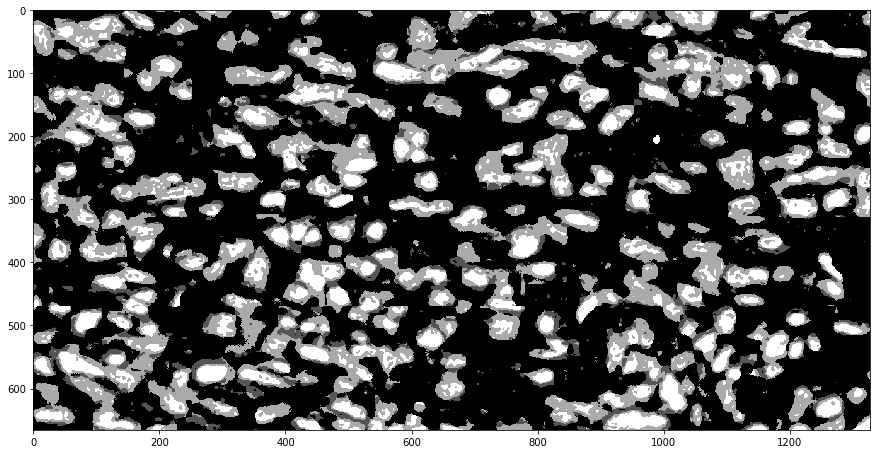

In [6]:
count_and_label(template_params)

Internally, the label values are conveniently increasing, regularly spaced integers.
Black is therefore background / negative, dark gray is weak positive, light gray is positive,
and white is strong positive.  To use the label values programmatically, use of the static
attributes of `ppc.Labels` &ndash; `.NEGATIVE`, `.WEAK`, `.PLAIN`, and `.STRONG` &ndash;
is recommended.

This does a reasonably good job aleady, but let's see what happens if we reduce the hue range a bit.
Since `Parameters` is a `collections.namedtuple`, we can use its `._replace` method to substitute a value.

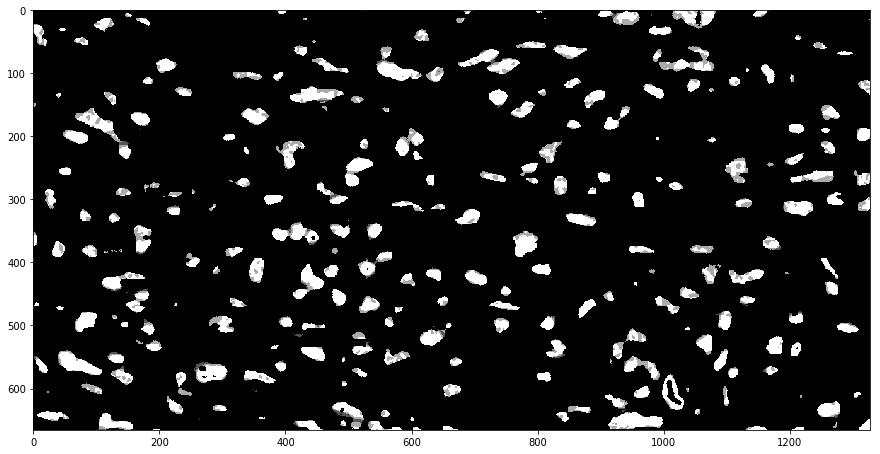

In [7]:
count_and_label(template_params._replace(hue_width=0.1))

In any case, we can also view the statistics.  Here we use the original parameter values.

In [8]:
stats, label_image = ppc.count_image(im_input, template_params)

def pp_namedtuple(t):
    "Pretty-print a namedtuple by printing each field on its own line and left-aligning all values"
    print(type(t).__name__)
    maxlen = max(map(len, t._fields))
    for f in t._fields:
        print(f, getattr(t, f), sep=':' + ' ' * (maxlen - len(f)) + '\t')

pp_namedtuple(stats)

Output
NumberWeakPositive:             	57342
NumberPositive:                 	200825
NumberStrongPositive:           	98267
IntensitySumWeakPositive:       	43782.7699346
IntensitySumPositive:           	96846.0405229
IntensitySumStrongPositive:     	26543.3555556
IntensityAverage:               	0.469012961763
RatioStrongToTotal:             	0.275694799037
IntensityAverageWeakAndPositive:	0.544720318466


## Analyzing a large image with `count_slide`
`count_slide` has several more parameters than `count_image`.  Besides `make_label_image`,
which controls the creation of the label image as mentioned, there is also `region`, which instructs
`count_slide` to operate on only the specified region of the image.

We will visualize its operation on a region, and then run it on the whole image.

### Additional setup
First, however, we'll need to download the image and set up Dask.
(The image is 644MiB, so the download takes a while.)

In [9]:
# Comment this out (or just don't run it) once you have the file
!curl -OJ 'https://data.kitware.com/api/v1/item/5899dd6c8d777f07219fcb22/download'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  643M  100  643M    0     0  2291k      0  0:04:47  0:04:47 --:--:-- 2142k 0:04:50  0:02:17  0:02:33 1928k     0  2376k      0  0:04:37  0:03:09  0:01:28 2419k
curl: Saved to filename 'TCGA-02-0010-01Z-00-DX4.07de2e55-a8fe-40ee-9e98-bcb78050b9f7.svs'


In [10]:
# Set up a basic configuration.  Change as needed.
import dask.distributed

dask.distributed.Client()

Client Scheduler: tcp://127.0.0.1:43767,Cluster Workers: 8 Cores: 8 Memory: 9.74 GB


### `count_slide` on a small region
Now we can inspect the image.  We'll first run the calculation to produce a label image,
and then run it again without, allowing parallelization.

Using python for large_image caching
The region


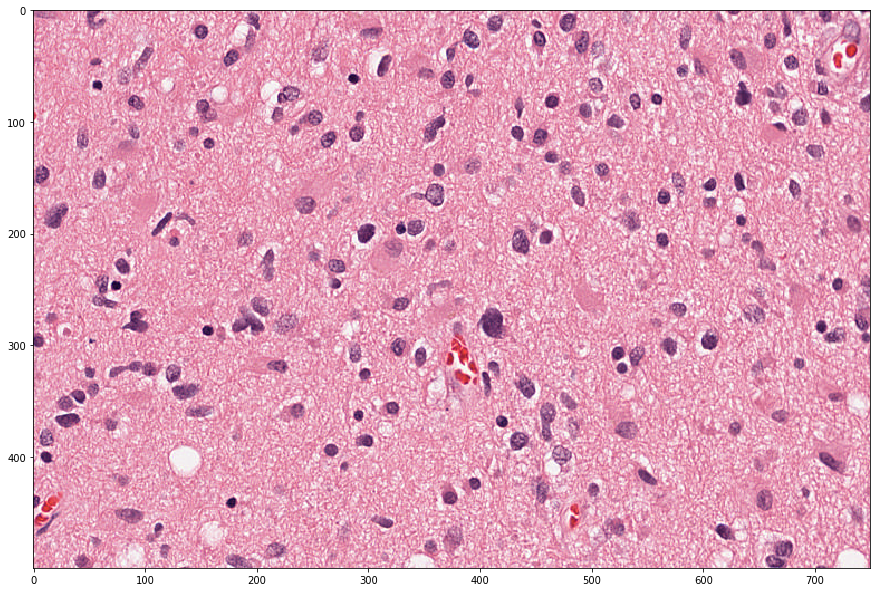

In [11]:
slide_path = 'TCGA-02-0010-01Z-00-DX4.07de2e55-a8fe-40ee-9e98-bcb78050b9f7.svs'
region = dict(
    top=5000, left=5000,
    width=750, height=500,
)

ts = large_image.getTileSource(slide_path)
im_region = ts.getRegion(region=region, format=large_image.tilesource.TILE_FORMAT_NUMPY)[0]

print("The region")
plt.imshow(im_region)
plt.show()

We'll reuse the parameters from before.

Output
NumberWeakPositive:             	15400
NumberPositive:                 	23896
NumberStrongPositive:           	3813
IntensitySumWeakPositive:       	11634.8196078
IntensitySumPositive:           	11996.1843137
IntensitySumStrongPositive:     	1124.8248366
IntensityAverage:               	0.574261262339
RatioStrongToTotal:             	0.0884502076133
IntensityAverageWeakAndPositive:	0.601359016734


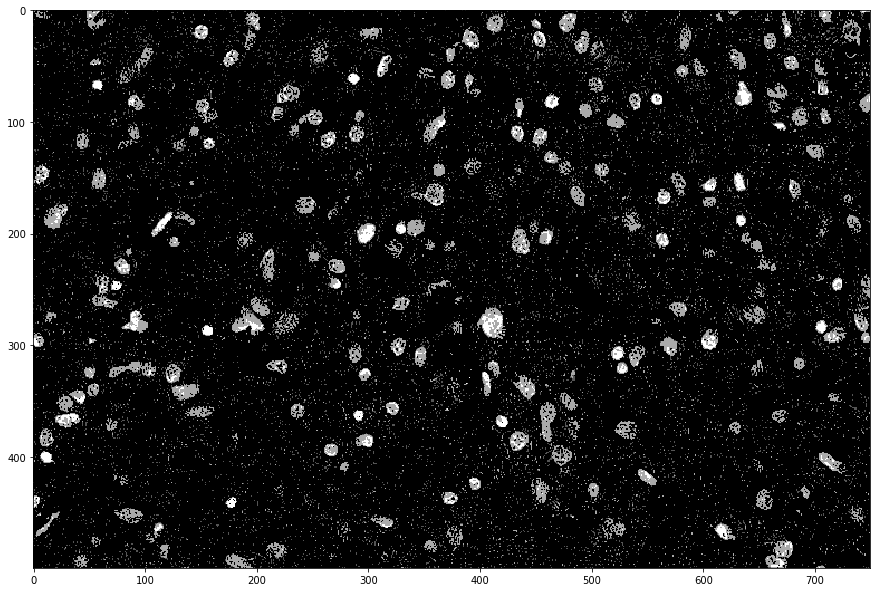

In [12]:
stats, label_image = ppc.count_slide(slide_path, template_params, region=region, make_label_image=True)
pp_namedtuple(stats)
plt.imshow(label_image)
plt.show()

It's not great.  Improving the result is left as an exercise for the reader.

We'll now rerun for only the stats, which will make use of Dask.  `make_label_image`
defaults to `False`, so we simply omit it here.  For the purposes of illustration,
we force `tile_grouping` to 1 to process each tile in its own task.  A larger value, 256,
is used as the default value to reduce the overhead associated with Dask tasks.

In [13]:
# Note that we still return a tuple, though it now has length 1.
stats_dask, = ppc.count_slide(slide_path, template_params, region=region, tile_grouping=1)
pp_namedtuple(stats_dask)

Output
NumberWeakPositive:             	15400
NumberPositive:                 	23896
NumberStrongPositive:           	3813
IntensitySumWeakPositive:       	11634.8196078
IntensitySumPositive:           	11996.1843137
IntensitySumStrongPositive:     	1124.8248366
IntensityAverage:               	0.574261262339
RatioStrongToTotal:             	0.0884502076133
IntensityAverageWeakAndPositive:	0.601359016734


The results are identical up to a tiny amount of floating point error, as can be seen below:

In [14]:
print("stats_dask - stats:")
pp_namedtuple(ppc.Output(**{f: getattr(stats_dask, f) - getattr(stats, f) for f in ppc.Output._fields}))

stats_dask - stats:
Output
NumberWeakPositive:             	0
NumberPositive:                 	0
NumberStrongPositive:           	0
IntensitySumWeakPositive:       	3.63797880709e-12
IntensitySumPositive:           	0.0
IntensitySumStrongPositive:     	0.0
IntensityAverage:               	0.0
RatioStrongToTotal:             	0.0
IntensityAverageWeakAndPositive:	1.11022302463e-16


### `count_slide` on the whole image
While it may not be especially useful, it is nevertheless possible to compute statistics
over the entire image in a parallelized manner.

In [15]:
print("Image width:", ts.sizeX, "height:", ts.sizeY)

stats, = %time ppc.count_slide(slide_path, template_params)

pp_namedtuple(stats)

Image width: 32001 height: 38474
CPU times: user 2.53 s, sys: 1.06 s, total: 3.59 s
Wall time: 53.4 s
Output
NumberWeakPositive:             	45466143
NumberPositive:                 	64976507
NumberStrongPositive:           	12754515
IntensitySumWeakPositive:       	35312108.1242
IntensitySumPositive:           	32538083.9477
IntensitySumStrongPositive:     	3610514.53464
IntensityAverage:               	0.580051550752
RatioStrongToTotal:             	0.103529289818
IntensityAverageWeakAndPositive:	0.614347736784


## The CLI
Finally, we briefly demonstrate the use of the CLI.  It takes arguments the same as or equivalent to those
of `count_slide`, as well as a `--scheduler_address` argument that is used to connect to an already running
Dask distributed scheduler if provided.

In [16]:
pp_namedtuple(template_params)
print('\nRegion:', region)

Parameters
hue_value:                 	0.8
hue_width:                 	0.2
saturation_minimum:        	0.05
intensity_upper_limit:     	0.95
intensity_weak_threshold:  	0.65
intensity_strong_threshold:	0.35
intensity_lower_limit:     	0.01

Region: {'width': 750, 'top': 5000, 'height': 500, 'left': 5000}


In [17]:
%%script sh
# Stats and label image output must be specified via file arguments to
# --returnparameterfile and --outputLabelImage, respectively.
python ../../server/PositivePixelCount/PositivePixelCount.py \
    'TCGA-02-0010-01Z-00-DX4.07de2e55-a8fe-40ee-9e98-bcb78050b9f7.svs' \
    0.8 0.2 0.05 0.95 0.65 0.35 0.01 --region 5000,5000,750,500 \
    --returnparameterfile stats.txt --outputLabelImage labelImage.png 2>/dev/null

Using python for large_image caching


Here are the results.  Note that, if a label image is output, it's colorized according to colors from
the [coolwarm](https://www.ncl.ucar.edu/Document/Graphics/ColorTables/MPL_coolwarm.shtml) color map.
White is negative, blue is weak positive, gray is positive, and red is strong positive.

stats.txt:
NumberWeakPositive = 15400
NumberPositive = 23896
NumberStrongPositive = 3813
IntensitySumWeakPositive = 11634.8196078
IntensitySumPositive = 11996.1843137
IntensitySumStrongPositive = 1124.8248366
IntensityAverage = 0.574261262339
RatioStrongToTotal = 0.0884502076133
IntensityAverageWeakAndPositive = 0.601359016734

labelImage.png:


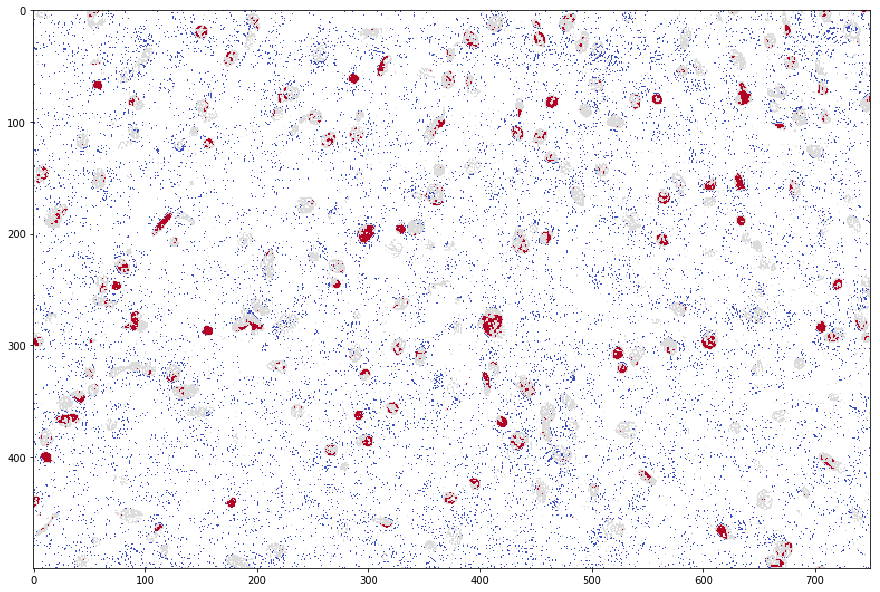

In [18]:
print("stats.txt:")
for l in open('stats.txt'):
    print(l.rstrip())

print("\nlabelImage.png:")
plt.imshow(skimage.io.imread('labelImage.png'))
plt.show()